<a href="https://colab.research.google.com/github/DarthCipher7/DR/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Cell 1: Mount Drive and Unzip Data ###

# Import necessary libraries
import os
import zipfile
from google.colab import drive

# Mount your Google Drive (this will require authentication)
drive.mount('/content/drive')

# Define the path to your zip file
zip_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'

# Define the directory to extract the data to
extract_path = '/content/data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip your data
print("Starting to unzip the data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Data unzipped successfully!")

# You can add this to see the contents of your unzipped folder
print("\nContents of the data folder:")
!ls /content/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting to unzip the data...
Data unzipped successfully!

Contents of the data folder:
data


In [16]:
### Cell 2: Load Labels and Prepare Data Generators (with Augmentation) ###

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_data_dir = '/content/data/data/gaussian_filtered_images/gaussian_filtered_images'

# --- UPGRADE: Create separate generators for training (with augmentation) and validation ---

# This is for the training data - we apply lots of random transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # Still split the data
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1, # Randomly shift images vertically
    shear_range=0.1,        # Apply shear transformations
    zoom_range=0.1,         # Randomly zoom in on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'
)

# This is for the validation data - we ONLY rescale it. No augmentation!
# We need to judge the model on the original, unmodified images.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# --- Create the generators using the new datagens ---

train_generator = train_datagen.flow_from_directory(
    directory=main_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=main_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [17]:
### Cell 3: Build the Model ###

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the VGG16 model without the top classification layer
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers of the base model so they don't get re-trained
base_model.trainable = False

# Create your new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax') # 5 classes for diabetic retinopathy (0-4)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Use this loss for multi-class classification
    metrics=['accuracy']
)

# Print a summary of your model's architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
### Cell 4: Train the Model (with Callbacks and More Epochs) ###

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- UPGRADE: Define callbacks ---

# Stop training if the validation loss doesn't improve for 5 consecutive epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True  # Automatically restore the best model weights at the end
)

# Save the best model found during training to a file
model_checkpoint = ModelCheckpoint(
    'best_retinopathy_model.keras', # File name to save the model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


# --- Train for more epochs ---
history = model.fit(
    train_generator,
    epochs=30,  # Increase the number of epochs significantly
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint] # Add the callbacks here
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.5800 - loss: 2.7578
Epoch 1: val_loss improved from inf to 0.88023, saving model to best_retinopathy_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 627ms/step - accuracy: 0.5804 - loss: 2.7458 - val_accuracy: 0.7059 - val_loss: 0.8802
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6592 - loss: 0.9350
Epoch 2: val_loss improved from 0.88023 to 0.85736, saving model to best_retinopathy_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.6593 - loss: 0.9348 - val_accuracy: 0.6949 - val_loss: 0.8574
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6818 - loss: 0.9086
Epoch 3: val_loss improved from 0.85736 to 0.80932, saving model to best_retinopathy_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 524ms/step - accuracy: 0.6819 - loss: 0.9084 - val_accuracy: 0.7031 - val_loss: 0.8093
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6977 - loss: 0.8928
Epoch 4: val_lo

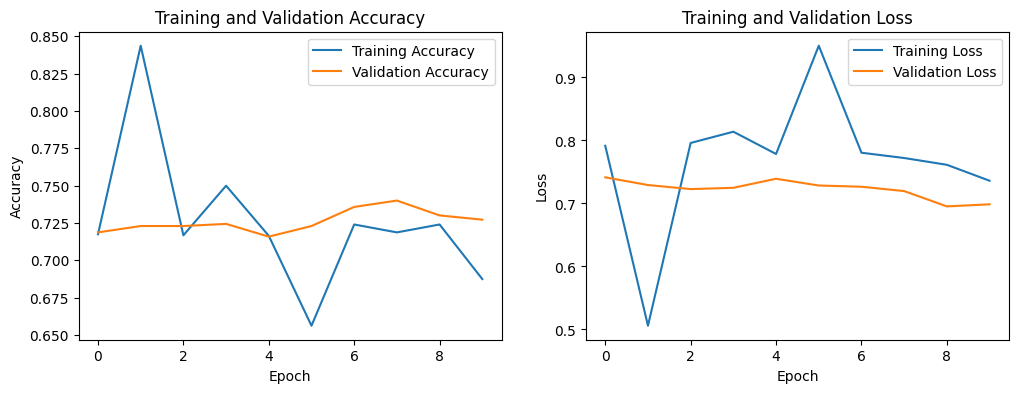

In [15]:
### Cell 5: Evaluate the Model ###

import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()